In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [2]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'

    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    df['Начало нед'] = pd.to_datetime(df['Начало нед'])
    df['ТВ реклама, руб'] = df['ТВ реклама, руб'].replace(' ', 0).astype(float)

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_38910/695145740.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ТВ реклама, руб'] = df['ТВ реклама, руб'].replace(' ', 0).astype(float)


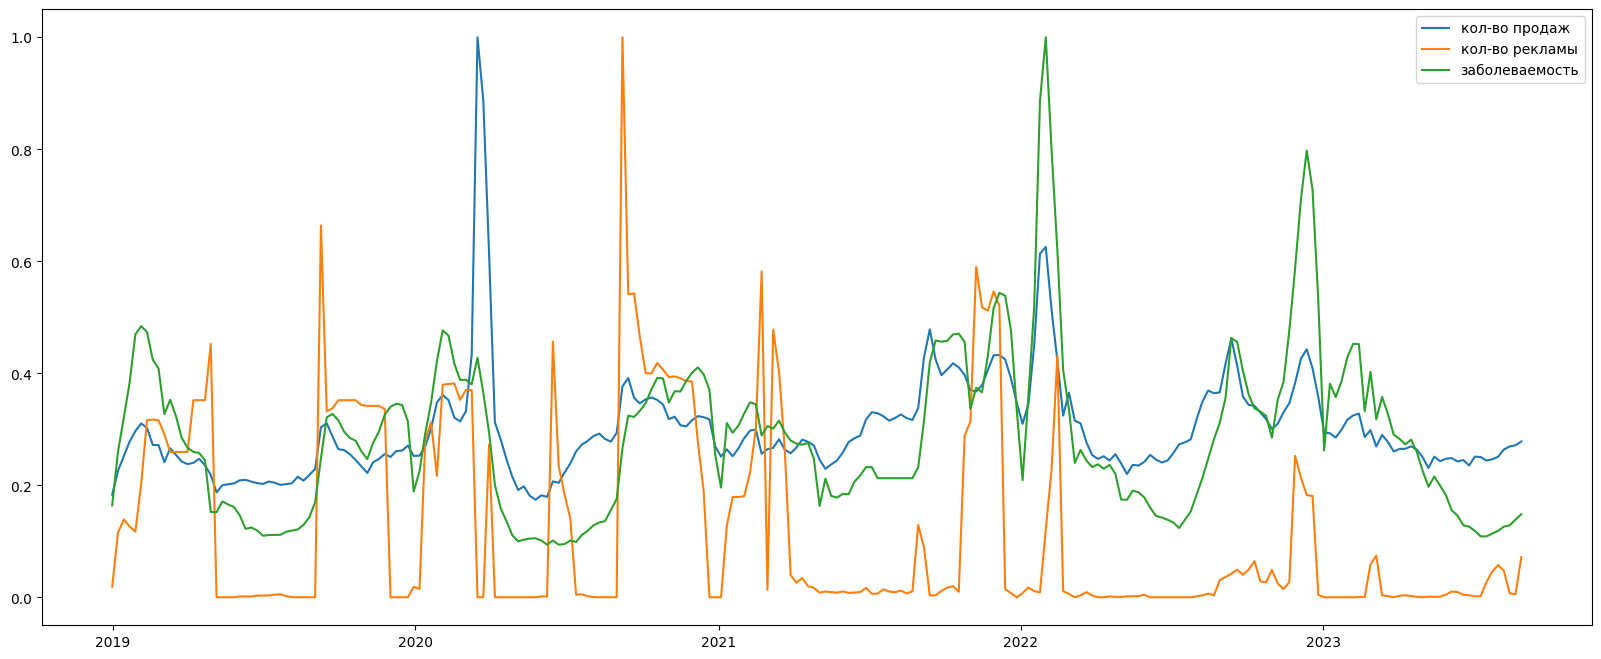

In [3]:
df['money'] = df['ТВ реклама, руб'] + df['интернет реклама, руб']

plt.figure(figsize=(20, 8))

cur_df = df[df.продажи.notna()]
plt.plot(cur_df['Начало нед'], cur_df['продажи'] / cur_df['продажи'].max())
plt.plot(cur_df['Начало нед'], cur_df['money'] / cur_df['money'].max())
plt.plot(cur_df['Начало нед'], cur_df['заболеваемость'] / cur_df['заболеваемость'].max())

plt.legend(['кол-во продаж', 'кол-во рекламы', 'заболеваемость'])

In [4]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    # week_info_dict = week_info.to_dict()
    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        df['week_sum'] -= df['продажи'].shift(-i)
        df['week_count'] -= 1
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count']
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1)
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1)
    df['feature_last_10_wordstat'] = df['wordstat'].shift(1).rolling(window=10).mean()

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)

In [5]:
df = df[df['target_1'].notna()].reset_index(drop=True)
df = df.loc[20:].reset_index(drop=True)

In [6]:
df[(df.target_2 > 1.5) | (df.target_2 < 0.7)]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,feature_mean_week_0,feature_mean_week_norm_0,feature_mean_week_1,feature_mean_week_norm_1,feature_mean_week_2,feature_mean_week_norm_2,feature_mean_week_3,feature_mean_week_norm_3,feature_mean_week_4,feature_mean_week_norm_4,feature_mean_week_5,feature_mean_week_norm_5,feature_mean_week_6,feature_mean_week_norm_6,feature_mean_week_7,feature_mean_week_norm_7,feature_mean_week_8,feature_mean_week_norm_8,feature_mean_week_9,feature_mean_week_norm_9,feature_mean_week_10,feature_mean_week_norm_10,feature_mean_week_11,feature_mean_week_norm_11,feature_mean_week_12,feature_mean_week_norm_12,feature_mean_week_13,feature_mean_week_norm_13,feature_mean_week_14,feature_mean_week_norm_14,feature_mean_week_15,feature_mean_week_norm_15,feature_mean_week_16,feature_mean_week_norm_16,feature_mean_week_17,feature_mean_week_norm_17,feature_mean_week_18,feature_mean_week_norm_18,feature_mean_week_19,feature_mean_week_norm_19,feature_mean_week_20,feature_mean_week_norm_20,feature_mean_week_21,feature_mean_week_norm_21,feature_mean_week_22,feature_mean_week_norm_22,feature_mean_week_23,feature_mean_week_norm_23,feature_mean_week_24,feature_mean_week_norm_24,feature_mean_week_25,feature_mean_week_norm_25,feature_mean_week_26,feature_mean_week_norm_26,feature_mean_week_27,feature_mean_week_norm_27,feature_mean_week_28,feature_mean_week_norm_28,feature_illnesses,feature_last_10_wordstat,feature_week,feature_month_diff_1,feature_month_diff_5,feature_month_diff_9,feature_month_diff_13,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks
41,1.305033,3.012287,2.671861,1.845095,0.940856,0.849886,0.742096,0.648757,0.577354,0.596378,0.546571,0.524824,0.548315,0.540176,0.623446,0.615647,0.670747,0.71988,0.78435,0.82159,0.840975,0.86732,0.880493,0.851622,0.837537,0.884246,1.134445,1.179222,1.073229,65146885.894125,0.864914,60828150.81525,0.807577,57498727.062,0.763374,57704078.08725,0.766101,58905852.2745,0.782056,58913969.942625,0.782164,58212600.17475,0.772852,54057471.38925,0.717687,49210200.8895,0.653333,52455173.97225,0.696414,52426663.435125,0.696036,53960882.7345,0.716405,56086527.60375,0.744625,55695405.82725,0.739433,55648499.33475,0.73881,56787324.517875,0.753929,59068858.881375,0.78422,60064208.358,0.797435,59491742.590875,0.789834,59243130.956625,0.786534,61869099.009375,0.821397,64827220.77825,0.86067,66589585.579125,0.884068,65846186.2275,0.874198,68073340.734,0.903767,81273412.248,1.079016,94100694.765,1.249316,86931367.593,1.154133,78813476.1645,1.046357,1203405,91730.310,11,0.91897,1.428326,0.968353,1.083389,1.101161,1.271049,1.355274
42,2.308208,2.047352,1.41383,0.720944,0.651237,0.568641,0.497119,0.442406,0.456983,0.418818,0.402154,0.420154,0.413917,0.477725,0.471748,0.51397,0.551618,0.60102,0.629555,0.644409,0.664596,0.674691,0.652568,0.641775,0.677566,0.869285,0.903596,0.822377,0.798812,60828150.81525,0.618817,57498727.062,0.584947,57704078.08725,0.587036,58905852.2745,0.599262,58913969.942625,0.599344,58212600.17475,0.592209,54057471.38925,0.549938,49210200.8895,0.500626,52455173.97225,0.533637,52426663.435125,0.533347,53960882.7345,0.548955,56086527.60375,0.57058,55695405.82725,0.566601,55648499.33475,0.566124,56787324.517875,0.577709,59068858.881375,0.60092,60064208.358,0.611046,59491742.590875,0.605222,59243130.956625,0.602693,61869099.009375,0.629407,64827220.77825,0.659501,66589585.579125,0.67743,65846186.2275,0.669867,68073340.734,0.692524,81273412.248,0.826811,94100694.765,0.957306,86931367.593,0.884371,78813476.1645,0.801786,76732350.7895,0.780614,1178877,95300.310,12,1.230225,1.306405,1.029309,1.060017,1.245374,1.654275,1.854942
43,0.886988,0.612523,0.312339,0.28214,0.246356,0.21537,0.191666,0.197982,0.181447,0.174228,0.182026,0

In [7]:
i = 1

cur_df = df.drop([43-i, 44-i, 45-i, 46-i])

cur_df.iloc[35:45]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,feature_mean_week_0,feature_mean_week_norm_0,feature_mean_week_1,feature_mean_week_norm_1,feature_mean_week_2,feature_mean_week_norm_2,feature_mean_week_3,feature_mean_week_norm_3,feature_mean_week_4,feature_mean_week_norm_4,feature_mean_week_5,feature_mean_week_norm_5,feature_mean_week_6,feature_mean_week_norm_6,feature_mean_week_7,feature_mean_week_norm_7,feature_mean_week_8,feature_mean_week_norm_8,feature_mean_week_9,feature_mean_week_norm_9,feature_mean_week_10,feature_mean_week_norm_10,feature_mean_week_11,feature_mean_week_norm_11,feature_mean_week_12,feature_mean_week_norm_12,feature_mean_week_13,feature_mean_week_norm_13,feature_mean_week_14,feature_mean_week_norm_14,feature_mean_week_15,feature_mean_week_norm_15,feature_mean_week_16,feature_mean_week_norm_16,feature_mean_week_17,feature_mean_week_norm_17,feature_mean_week_18,feature_mean_week_norm_18,feature_mean_week_19,feature_mean_week_norm_19,feature_mean_week_20,feature_mean_week_norm_20,feature_mean_week_21,feature_mean_week_norm_21,feature_mean_week_22,feature_mean_week_norm_22,feature_mean_week_23,feature_mean_week_norm_23,feature_mean_week_24,feature_mean_week_norm_24,feature_mean_week_25,feature_mean_week_norm_25,feature_mean_week_26,feature_mean_week_norm_26,feature_mean_week_27,feature_mean_week_norm_27,feature_mean_week_28,feature_mean_week_norm_28,feature_illnesses,feature_last_10_wordstat,feature_week,feature_month_diff_1,feature_month_diff_5,feature_month_diff_9,feature_month_diff_13,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks
35,1.153911,1.198256,1.168121,1.063807,1.041831,1.101161,1.437052,3.317014,2.94215,2.031747,1.036034,0.935861,0.817167,0.714386,0.63576,0.656709,0.601863,0.577916,0.603783,0.59482,0.686515,0.677927,0.738601,0.792704,0.863696,0.904703,0.926049,0.955059,0.969565,86433442.452,1.263607,82005612.609375,1.198875,76711288.891125,1.121475,64609863.1815,0.944559,68059184.97,0.994986,61986115.571625,0.906201,65146885.894125,0.95241,60828150.81525,0.889273,57498727.062,0.840598,57704078.08725,0.8436,58905852.2745,0.86117,58913969.942625,0.861288,58212600.17475,0.851035,54057471.38925,0.790289,49210200.8895,0.719425,52455173.97225,0.766864,52426663.435125,0.766448,53960882.7345,0.788877,56086527.60375,0.819953,55695405.82725,0.814235,55648499.33475,0.813549,56787324.517875,0.830198,59068858.881375,0.863553,60064208.358,0.878104,59491742.590875,0.869735,59243130.956625,0.8661,61869099.009375,0.904491,64827220.77825,0.947737,66589585.579125,0.973501,1077699,82658.940,5,1.112652,1.059214,1.095255,0.883114,1.154281,1.290797,0.993162
36,1.03843,1.012315,0.921914,0.902869,0.954286,1.245374,2.874583,2.549719,1.760748,0.897846,0.811034,0.708171,0.619099,0.550961,0.569115,0.521585,0.500832,0.523249,0.515482,0.594946,0.587503,0.640084,0.686971,0.748494,0.784032,0.80253,0.827671,0.840243,0.812691,82005612.609375,1.038966,76711288.891125,0.97189,64609863.1815,0.818572,68059184.97,0.862273,61986115.571625,0.78533,65146885.894125,0.825375,60828150.81525,0.770659,57498727.062,0.728477,57704078.08725,0.731079,58905852.2745,0.746305,58913969.942625,0.746408,58212600.17475,0.737522,54057471.38925,0.684879,49210200.8895,0.623466,52455173.97225,0.664578,52426663.435125,0.664217,53960882.7345,0.683655,56086527.60375,0.710586,55695405.82725,0.70563,55648499.33475,0.705036,56787324.517875,0.719464,59068858.881375,0.74837,60064208.358,0.760981,59491742.590875,0.753728,59243130.956625,0.750578,61869099.009375,0.783848,64827220.77825,0.821325,66589585.579125,0.843654,65846186.2275,0.834235,1307649,84954.660,6,1.378577,1.007155,1.128655,0.844563,1.328336,1.56707,1.119489
37,0.974851,0.887796,0.869456,0.91897,1.199286,2.768202,2.45536,1.695587,0.864619,0.7810

In [8]:
test_size = 0.35 # 0.4

from sklearn.model_selection import train_test_split

all_models = []
all_metrics = []
all_preds = []
for i in range(1, 30):
    print(f'Предсказываение на {i} недель вперед')

    cur_df = df[df[f'target_{i}'].notna()]

    cur_df = cur_df.drop([43-i, 44-i, 45-i, 46-i])

    for j in range(1, 30):
        if abs(i - j) >= 20:
            cur_df = cur_df.drop([f'feature_mean_week_{j-1}', f'feature_mean_week_norm_{j-1}'], axis=1)

    # train_data, valid_data = train_test_split(cur_df, test_size=test_size, random_state=42)

    train_data, valid_data = cur_df[:int(len(cur_df) * (1-test_size))], cur_df[int(len(cur_df) * (1-test_size)):]

    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=2,
        learning_rate=0.03,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='R2',

        random_state=42,
        thread_count=5
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000)
    all_models.append(model)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
0:	learn: -0.0046486	test: -0.0012031	best: -0.0012031 (0)	total: 54.7ms	remaining: 2m 44s
1000:	learn: 0.5058597	test: 0.2549598	best: 0.2549726 (999)	total: 322ms	remaining: 644ms
2000:	learn: 0.5847199	test: 0.2848968	best: 0.2862929 (1948)	total: 539ms	remaining: 269ms
2999:	learn: 0.6380592	test: 0.2915227	best: 0.2929103 (2951)	total: 784ms	remaining: 0us

bestTest = 0.2929103418
bestIteration = 2951

Shrink model to first 2952 iterations.
R2: 0.29291
MAPE: 0.04438

Предсказываение на 2 недель вперед
0:	learn: -0.0038358	test: 0.0047667	best: 0.0047667 (0)	total: 867us	remaining: 2.6s
1000:	learn: 0.6192792	test: 0.1832586	best: 0.2145628 (553)	total: 236ms	remaining: 471ms
2000:	learn: 0.6883107	test: 0.1562316	best: 0.2145628 (553)	total: 470ms	remaining: 234ms
2999:	learn: 0.7234392	test: 0.1639867	best: 0.2145628 (553)	total: 686ms	remaining: 0us

bestTest = 0.2145627516
bestIteration = 553

Shrink model to first 554 iterations.
R2: 0.21456


In [9]:
with open("models.pkl", "wb") as file:
    pickle.dump(all_models, file)

In [10]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': all_models[-1].get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
21,feature_mean_week_norm_19,8.785768
49,feature_big_diff_20_weeks,7.304645
17,feature_mean_week_norm_17,5.904880
48,feature_big_diff_13_weeks,5.333024
13,feature_mean_week_norm_15,4.986005
41,feature_last_10_wordstat,4.805650
23,feature_mean_week_norm_20,4.758623
39,feature_mean_week_norm_28,4.200440
27,feature_mean_week_norm_22,3.724526
19,feature_mean_week_norm_18,3.667132


In [11]:
print(f'R2: {round(np.mean([x[0] for x in all_metrics]), 5)}')
print(f'MAPE: {round(np.mean([x[1] for x in all_metrics]), 5)}')

R2: 0.64563
MAPE: 0.13239


R2: 0.42683
MAPE: 0.10619

In [12]:
cur_df = df[df[f'target_29'].notna()]


preds = [all_models[i].predict(cur_df[[col for col in cur_df.columns if 'feature' in col]].iloc[[-10]])[0] for i in range(29)]

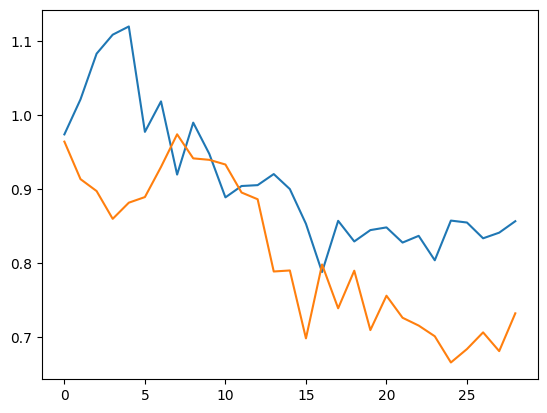

In [13]:
plt.plot([cur_df.iloc[-5][f'target_{i}'] for i in range(1, 30)])
plt.plot(preds)

-----

In [22]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [23]:
all_models = pickle.load(open('models.pkl', 'rb'))

In [24]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [25]:
df[df['год'].notna()]

,год,неделя,Начало нед,продажи,"Продажи, рубли","Продажи, упаковки","Продажи, рубли","Продажи, рубли","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки","раствор 0.01 % 50 мл N1, упаковки","раствор 0.01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,заболеваемость,Индекс цены,Развитие Дженериков \n(средняя дистрибуция),Развитие Дженериков \n(кол-во брендов),"(1)\nТВ, trp\n(Ж 30-60 ВС)","(1)\nТВ, рубли","(1)\nТВ, охват 5+\n(Ж 30-60 ВС)","(2)\nТВ, trp\n(Ж 30-60 ВС)","(2)\nТВ, рубли","(2)\nТВ, охват 5+\n(Ж 30-60 ВС)","(3)\nТВ, trp\n(Ж 30-60 ВС)","(3)\nТВ, рубли","(3)\nТВ, охват 5+\n(Ж 30-60 ВС)","(4)\nТВ, trp\n(Ж 30-60 ВС)","(4)\nТВ, рубли","(4)\nТВ, охват 5+\n(Ж 30-60 ВС)","(тотал)\nТВ, trp\n(Ж 30-60 ВС)","ТВ реклама, руб","(тотал)\nТВ, охват 5+\n(Ж 30-60 ВС)","интернет реклама, руб","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, количество выходов",wordstat,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб",...,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли",Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого
5,2019,1,2018-12-31 00:00:00,41535567.339,0,114621.15,41535567.339,0,0,0,0,0,0,0,0.92107,99698.595433,508956,1.54132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,1057612.5,0,0,0,0,0,0,0,0,0

In [26]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count']
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1)
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1)
    df['feature_last_10_wordstat'] = df['wordstat'].shift(1).rolling(window=10).mean()

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    return df

df = create_features(df)
df = df.reset_index(drop=True)

In [35]:
max_id = df[df['target_1'].notna()].index.max()

preds = [df.iloc[max_id]['продажи'] * model.predict(df[model.feature_names_].iloc[max_id+1]) for model in all_models]

sample = pd.DataFrame({
    'week': ['04.09.2023', '11.09.2023', '18.09.2023', '25.09.2023', '02.10.2023', '09.10.2023', '16.10.2023', '23.10.2023', '30.10.2023', '06.11.2023', '13.11.2023', '20.11.2023', '27.11.2023', '04.12.2023', '11.12.2023', '18.12.2023', '25.12.2023', '01.01.2024', '08.01.2024', '15.01.2024', '22.01.2024', '29.01.2024', '05.02.2024', '12.02.2024', '19.02.2024', '26.02.2024', '04.03.2024', '11.03.2024', '18.03.2024'],
    'revenue': preds
})

sample.to_csv('answer_4.csv', index=False)

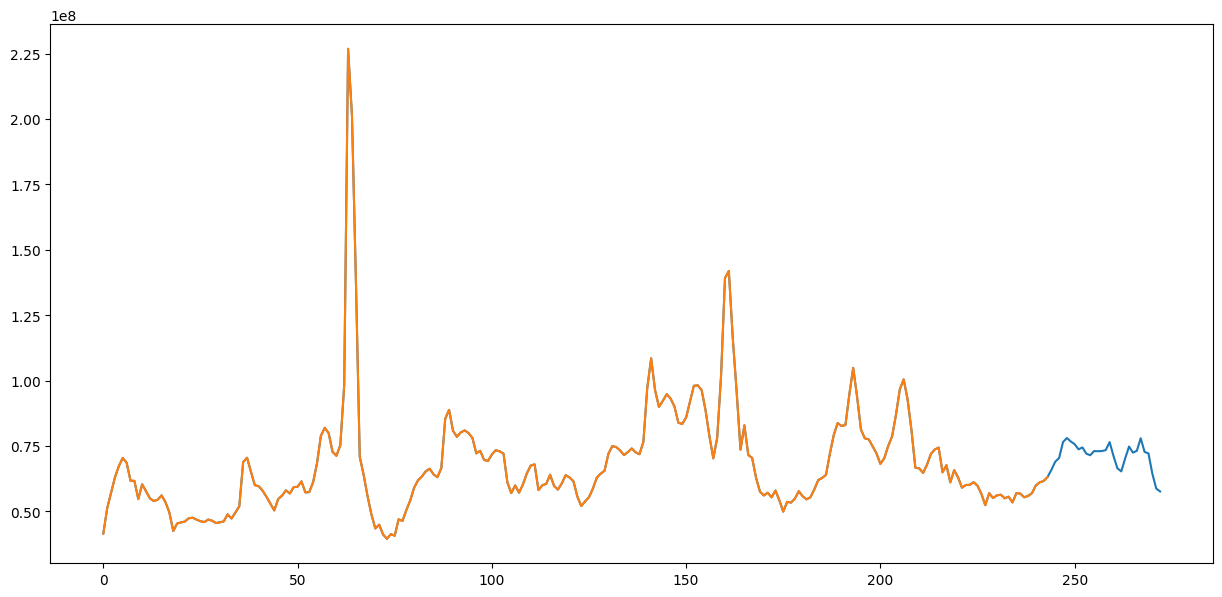

In [36]:
prev = df[df['продажи'].notna()]['продажи'].tolist()

plt.figure(figsize=(15, 7))

plt.plot(prev + preds)
plt.plot(prev)